# Imports and Setup

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from xgboost import XGBClassifier

from sklearn.linear_model import LogisticRegression
warnings.filterwarnings('ignore')
import re
import nltk
from nltk.corpus import stopwords,wordnet
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup





In [ ]:
# Download stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')  # This is needed for wordnet

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

## Load the Dataset

In [ ]:
df = pd.read_csv("/kaggle/input/new-duplicate-question/train.csv")


## Exploratory Data Analysis (EDA)

In [ ]:
#checking the shape of the dataset

df.shape


(404290, 6)

In [ ]:
#checking few rows
df.sample(10)

,id,qid1,qid2,question1,question2,is_duplicate
316947,316947,442069,45045,When can we expect global warming to be the mo...,What does global warming mean?,0
79561,79561,135446,135447,What do I need to start a personal support age...,What do I need to start a personal support wor...,1
102795,102795,170029,170030,What is current setting in relay?,How does contactor and relay works?,0
305930,305930,42615,15309,What do you think of Mr. Modi's decision to di...,What are your views on the decision of Narendr...,1
163540,163540,254357,254358,Why are the Indians action movies so fake and ...,Why do Indian movies blatantly rely on fiction...,0
296600,296600,418831,418832,Which is the best website to buy Naruto Tshirt...,Which is the best website to buy tshirts in In...,0
80643,80643,89405,15288,What is the best site to download films?,What are the best sites to download movies?,1
353605,353605,482690,16120,How can I receive multiple items together on f...,How do I pay for an item on flipkart.com since...,0
199408,199408,162603,22724,What are the strongest majors in terms of job ...,What are the strongest majors in terms of job ...,0
124282,124282,200727,200728,How were Gestapo prisoners treated by the Sovi...,How did Soviets treat German POWs after World ...,0


In [ ]:
# summary of the dataset, including the data types of each column and the number of non-null entries
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [ ]:
#to check the null value
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

As the number of null values are negligible infront of the size of dataset. We will drop the rows completely.

In [ ]:
df.dropna(inplace = True)

In [ ]:
df.shape

(404287, 6)

In [ ]:
# to check if the duplicate values are dropeed or not
df.duplicated().sum()

0

is_duplicate
0    255024
1    149263
Name: count, dtype: int64
is_duplicate
0    63.079941
1    36.920059
Name: count, dtype: float64


<Axes: xlabel='is_duplicate'>

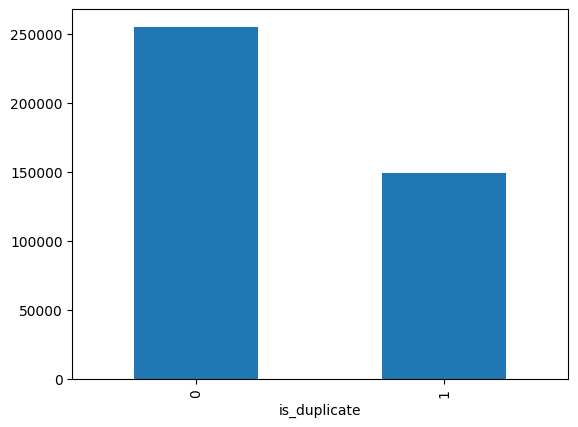

In [ ]:
#to check the distribution of duplicate and non-duplicate distribution of data
print(df['is_duplicate'].value_counts())
print((df['is_duplicate'].value_counts()/df['is_duplicate'].count())*100)
df['is_duplicate'].value_counts().plot(kind='bar')

The above bar graph and percentage shows that the datasets are unbalanced as there is more dataset which are non duplicate than duplicate.

After Dropping the null values from the dataset, assigning new dataset

In [ ]:
new_df = df

# **Preprocessing**

In the preprocessing phase of our analysis, I implemented several steps to clean and prepare the dataset before model evaluation.
1. Replaced certain special characters with their string equivalents to ensure consistency in the text data.
2. Notably, the pattern '[math]' appeared around 900 times throughout the dataset, which is addressed by substituting it with a more readable string format.
3.Additionally, converted some numerical values into their string equivalents.
4.At last, decontracted words to their full forms, removed HTML tags, and eliminated punctuations to streamline the textual data for better processing by the model.

In [ ]:
def preprocess(q):

    q = str(q).lower().strip()

    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')

    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')

    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)

    # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953

    contractions = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")

    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()

    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()


    return q


In [ ]:
#to check how Preprocessing works here, in the below exmple it converted the "I've already! wasn't <b>done</b>?"  to 'i have already  was not done'
preprocess("I've already! wasn't <b>done</b>?")

'i have already  was not done'

In [ ]:
# Apply preprocessing to the question1 and question2
new_df['question1'] = new_df['question1'].fillna("").apply(preprocess)
new_df['question2'] = new_df['question2'].fillna("").apply(preprocess)

In [ ]:
#checking the dataset after preprocess of the dataset
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when 23 24 math is divi...,0
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0


# **Feature Engineering**
After prepossesing, implement feature engineering which are as follow:

* q1 len: char length of question1.

* q2 len: char length of question2.

* q1 num words: Numberofwords in question1 obtained by splitting the ques
tions in the question1 column using ” ”.

* q2 num words: Numberofwords in question2 obtained by splitting the ques
tions in the question2 column using ” ”.

* word common: number of common unique words obtained by taking the
intersection of the set of collection of all words in question1 and question2.

* word total: sum of the total number of words in question1 and question2
 obtained by taking the sum of a set of collections of all words in question1 and question2.

* word share: word common/word total


In [ ]:
#Feature Engineering
new_df['q1_len'] = new_df['question1'].str.len()
new_df['q2_len'] = new_df['question2'].str.len()


In [ ]:
#checking the dataset after adding two features q1_len and q2_len
new_df.head()


,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,65,56
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,50,87
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,72,58
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when 23 24 math is divi...,0,49,58
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,75,38


minimum characters 0
maximum characters 621
average num of characters 58


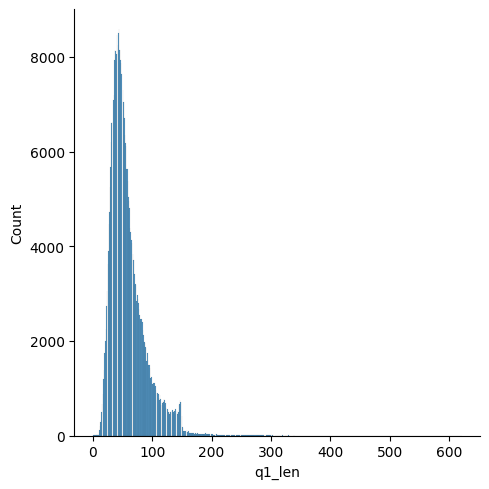

In [ ]:
# plot of the number length of questions in question1 set
sns.displot(new_df['q1_len'])
print('minimum characters', new_df['q1_len'].min())
print('maximum characters', new_df['q1_len'].max())
print('average num of characters', int(new_df['q1_len'].mean()))

minimum characters 0
maximum characters 1170
average num of characters 59


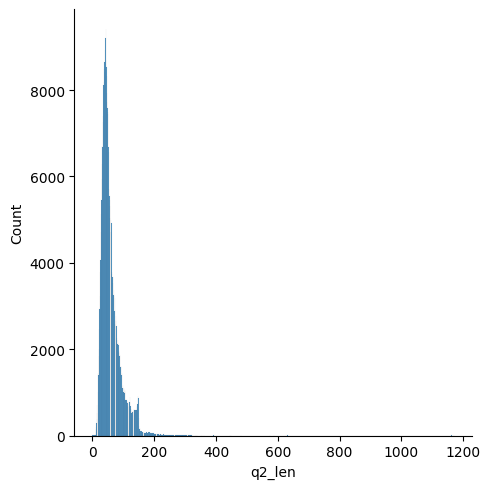

In [ ]:
# plot of the number length of questions in question2 set
sns.displot(new_df['q2_len'])
print('minimum characters', new_df['q2_len'].min())
print('maximum characters', new_df['q2_len'].max())
print('average num of characters', int(new_df['q2_len'].mean()))

In [ ]:
# to calculate the number of words in question1 and question2
new_df['q1_num_words'] = new_df['question1'].apply(lambda row: len(row.split(" ")))
new_df['q2_num_words'] = new_df['question2'].apply(lambda row: len(row.split(" ")))
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,65,56,14,12
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,50,87,12,17
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,72,58,14,10
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when 23 24 math is divi...,0,49,58,12,16
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,75,38,15,7


minimum words 1
maximum words 147
average num of words 11


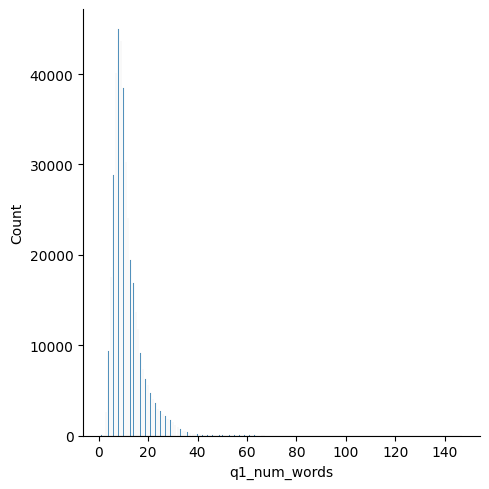

In [ ]:
sns.displot(new_df['q1_num_words'])
print('minimum words',new_df['q1_num_words'].min())
print('maximum words',new_df['q1_num_words'].max())
print('average num of words',int(new_df['q1_num_words'].mean()))

minimum words 1
maximum words 270
average num of words 11


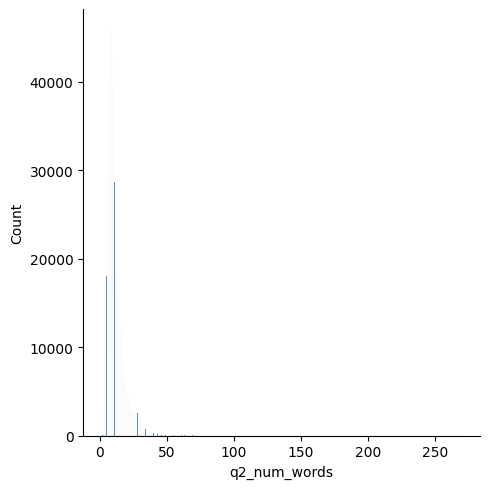

In [ ]:
sns.displot(new_df['q2_num_words'])
print('minimum words',new_df['q2_num_words'].min())
print('maximum words',new_df['q2_num_words'].max())
print('average num of words',int(new_df['q2_num_words'].mean()))

In [ ]:
def common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return len(w1 & w2)

In [ ]:
# to calculate common words
new_df['word_common'] = new_df.apply(common_words, axis=1)


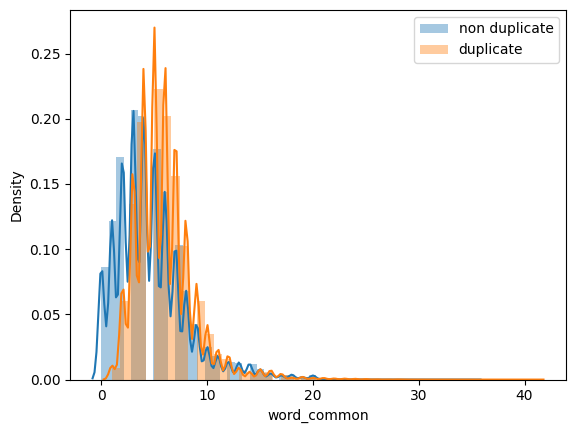

In [ ]:
# common words
sns.distplot(new_df[new_df['is_duplicate'] == 0]['word_common'],label='non duplicate')
sns.distplot(new_df[new_df['is_duplicate'] == 1]['word_common'],label='duplicate')
plt.legend()
plt.show()

In [ ]:
def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return (len(w1) + len(w2))

In [ ]:
#checking the dataset after adding word total feature
new_df['word_total'] = new_df.apply(total_words, axis=1)
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,65,56,14,12,11,23
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,50,87,12,17,8,26
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,72,58,14,10,4,24
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when 23 24 math is divi...,0,49,58,12,16,1,22
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,75,38,15,7,4,21


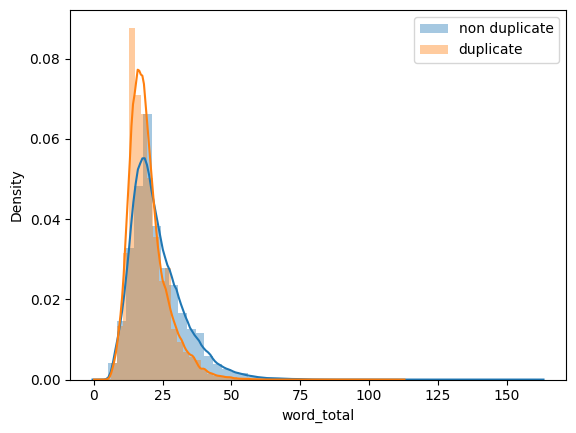

In [ ]:
# total words
sns.distplot(new_df[new_df['is_duplicate'] == 0]['word_total'],label='non duplicate')
sns.distplot(new_df[new_df['is_duplicate'] == 1]['word_total'],label='duplicate')
plt.legend()
plt.show()

In [ ]:
# Calculate word_share, setting it to 0 when word_total is 0 to avoid division by zero
new_df['word_share'] = new_df.apply(lambda row: round(row['word_common'] / row['word_total'], 2) if row['word_total'] != 0 else 0, axis=1)

# Check the result
new_df.head()


,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,65,56,14,12,11,23,0.48
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,50,87,12,17,8,26,0.31
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,72,58,14,10,4,24,0.17
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when 23 24 math is divi...,0,49,58,12,16,1,22,0.05
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,75,38,15,7,4,21,0.19


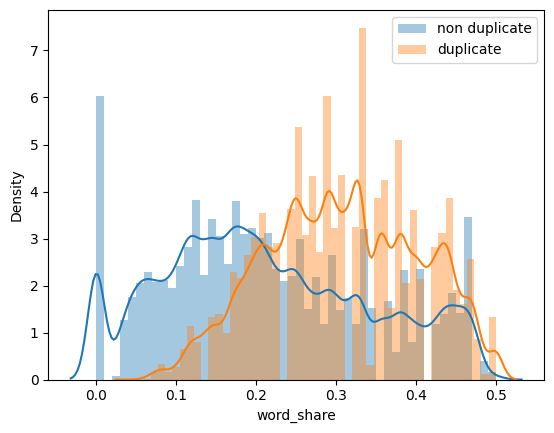

In [ ]:
# word share
sns.distplot(new_df[new_df['is_duplicate'] == 0]['word_share'],label='non duplicate')
sns.distplot(new_df[new_df['is_duplicate'] == 1]['word_share'],label='duplicate')
plt.legend()
plt.show()

# **Advanced Features**

**1. Token Features**


*   **cwc_min:** This is the ratio of the number of common words to the length of the smaller question.
*   **cwc_max:** This is the ratio of the number of common words to the length of the larger question.
*  **cwc_max:** This is the ratio of the number of common words to the length of the larger question.
*  **csc_min:** This is the ratio of the number of common stop words to the smaller stop word count among the two questions.
* **csc_max:** This is the ratio of the number of common stop words to the larger stop word count among the two questions.
* **ctc_min:** This is the ratio of the number of common tokens to the smaller token count among the two questions.
* **ctc_max:** This is the ratio of the number of common tokens to the larger token count among the two questions.
* **last_word_eq:** 1 if the last word in the two questions is same, 0 otherwise
* **first_word_eq:** 1 if the first word in the two questions is same, 0 otherwise.


**2. Fuzzy Features**
* **fuzz_ratio:** fuzz_ratio score from fuzzywuzzy.
This feature represents the fuzz_ratio score from fuzzywuzzy, which measures the simple edit distance between two strings.
* **fuzz_partial_ratio:** fuzz_partial_ratio from fuzzywuzzy.This feature captures the fuzz_partial_ratio from fuzzywuzzy, focusing on the best partial match of shorter substrings within the longer string.
* **token_sort_ratio:** token_sort_ratio from fuzzywuzzy, which sorts the tokens in each string and then computes the fuzz_ratio, effectively normalizing word order differences.
* **token_set_ratio:** token_set_ratio from fuzzywuzzy,which handles duplicate tokens and token order variations by considering the intersection and differences between token sets.

In [ ]:
def fetch_token_features(row):

    q1 = row['question1']
    q2 = row['question2']

    SAFE_DIV = 0.0001

    STOP_WORDS = stopwords.words("english")

    token_features = [0.0]*8

    # Converting the Sentence into Tokens:
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])

    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])

    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))

    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))

    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))


    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)

    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])

    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])

    return token_features

In [ ]:
token_features = new_df.apply(fetch_token_features, axis=1)

new_df["cwc_min"]       = list(map(lambda x: x[0], token_features))
new_df["cwc_max"]       = list(map(lambda x: x[1], token_features))
new_df["csc_min"]       = list(map(lambda x: x[2], token_features))
new_df["csc_max"]       = list(map(lambda x: x[3], token_features))
new_df["ctc_min"]       = list(map(lambda x: x[4], token_features))
new_df["ctc_max"]       = list(map(lambda x: x[5], token_features))
new_df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
new_df["first_word_eq"] = list(map(lambda x: x[7], token_features))

In [ ]:
#after appliying the advances token feature checking the dataset and shape of data
print(new_df.shape)
new_df.head()

(404287, 21)


,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,word_total,word_share,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,65,56,14,12,...,23,0.48,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,50,87,12,17,...,26,0.31,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,72,58,14,10,...,24,0.17,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when 23 24 math is divi...,0,49,58,12,16,...,22,0.05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,75,38,15,7,...,21,0.19,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0


In [ ]:
# Fuzzy Features
from fuzzywuzzy import fuzz

def fetch_fuzzy_features(row):

    q1 = row['question1']
    q2 = row['question2']

    fuzzy_features = [0.0]*4

    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [ ]:
fuzzy_features = new_df.apply(fetch_fuzzy_features, axis=1)

# Creating new feature columns for fuzzy features
new_df['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
new_df['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
new_df['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
new_df['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

In [ ]:
#after appliying the advances token feature checking the dataset and shape of data
print(new_df.shape)
new_df.head()

(404287, 25)


,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,65,56,14,12,...,0.999983,0.999983,0.916659,0.785709,0.0,1.0,93,100,93,100
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,50,87,12,17,...,0.749981,0.599988,0.699993,0.466664,0.0,1.0,66,74,63,86
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,72,58,14,10,...,0.399992,0.249997,0.399996,0.285712,0.0,1.0,43,46,63,63
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when 23 24 math is divi...,0,49,58,12,16,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,9,11,25,28
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,75,38,15,7,...,0.999950,0.666644,0.571420,0.307690,0.0,1.0,35,55,47,67


# **Splitting Data into Training and Testing Sets**

Before splitting the data into training and testing sets , I dropped the column id,qid1,qid2,question1,question2.

In [ ]:
new_df = new_df.drop(columns=['id','qid1','qid2','question1','question2'])
print(new_df.shape)
new_df.head()



(404287, 20)


,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
0,0,65,56,14,12,11,23,0.48,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,93,100,93,100
1,0,50,87,12,17,8,26,0.31,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,66,74,63,86
2,0,72,58,14,10,4,24,0.17,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,43,46,63,63
3,0,49,58,12,16,1,22,0.05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,9,11,25,28
4,0,75,38,15,7,4,21,0.19,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,35,55,47,67


## splitting data into X and y.

In [ ]:
y = new_df['is_duplicate']
X = new_df.drop('is_duplicate', axis=1)

## Splitting into X_train,X_test,y_train and y_test

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1875, random_state=42)
print('X_train is {}, X_test is {}, y_train is {} and y_test is {}'.format(X_train.shape, X_test.shape, y_train.shape, y_test.shape))

X_train is (262786, 19), X_test is (80858, 19), y_train is (262786,) and y_test is (80858,)


In [ ]:
X_train

,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
232040,39,35,7,8,3,15,0.20,0.333322,0.333322,0.499988,0.399992,0.428565,0.374995,0.0,0.0,57,58,62,62
397544,60,30,14,6,3,20,0.15,0.333322,0.199996,0.666644,0.222220,0.499992,0.214284,0.0,0.0,31,47,40,60
385450,26,62,5,14,0,18,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,30,42,28,28
398386,109,128,20,24,9,42,0.21,0.444440,0.333331,0.499995,0.454541,0.449998,0.374998,0.0,1.0,41,47,53,52
66422,38,44,6,7,2,13,0.15,0.333322,0.249994,0.333322,0.333322,0.333328,0.285710,0.0,1.0,56,61,59,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1743,139,243,23,47,9,57,0.16,0.181817,0.111110,0.699993,0.411762,0.391303,0.195652,0.0,1.0,5,37,2,44
220097,56,48,10,10,3,20,0.15,0.333328,0.333328,0.249994,0.249994,0.299997,0.299997,0.0,0.0,23,35,56,58
219756,54,51,11,10,8,21,0.38,0.599988,0.599988,0.999975,0.799984,0.777769,0.699993,1.0,1.0,86,82,83,83
240867,85,55,15,10,3,22,0.14,0.249994,0.142855,0.399992,0.333328,0.299997,0.199999,0.0,0.0,40,45,47,51


# **MODELS**

## RandomForest

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [300, 500],
    'criterion': ['gini', 'log_loss'],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False],
    'class_weight': ['balanced', None]
}

In [ ]:
# Instantiate the RandomForestClassifier
rf = RandomForestClassifier()

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=2, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy score: ", grid_search.best_score_)

# Use the best estimator to make predictions
best_rf = grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)

# Evaluate the best estimator
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

Fitting 2 folds for each of 64 candidates, totalling 128 fits
[CV] END C=0.01, class_weight=balanced, penalty=l2, solver=liblinear; total time=   5.5s
[CV] END C=0.1, class_weight=none, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.1, class_weight=none, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=1, class_weight=balanced, penalty=l2, solver=liblinear; total time=   6.5s
[CV] END bootstrap=True, class_weight=balanced, criterion=gini, max_features=sqrt, min_samples_split=2, n_estimators=500; total time= 4.2min
[CV] END C=0.01, class_weight=balanced, penalty=l2, solver=liblinear; total time=   6.0s
[CV] END C=1, class_weight=balanced, penalty=l2, solver=liblinear; total time=   6.6s
[CV] END bootstrap=True, class_weight=balanced, criterion=gini, max_features=sqrt, min_samples_split=2, n_estimators=500; total time= 4.3min
[CV] END C=0.01, class_weight=none, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.1, class_weight=balanced, penalty=l2, so

In [ ]:
# Print the evaluation results
print("Random Forest - Best Estimator - Accuracy:", accuracy_rf)
print("Random Forest - Best Estimator - Precision:", precision_rf)
print("Random Forest - Best Estimator - Recall:", recall_rf)
print("Random Forest - Best Estimator - F1 Score:", f1_rf)

Random Forest - Best Estimator - Accuracy: 0.7668752628064014
Random Forest - Best Estimator - Precision: 0.667941032542207
Random Forest - Best Estimator - Recall: 0.732066237597211
Random Forest - Best Estimator - F1 Score: 0.69853505629478


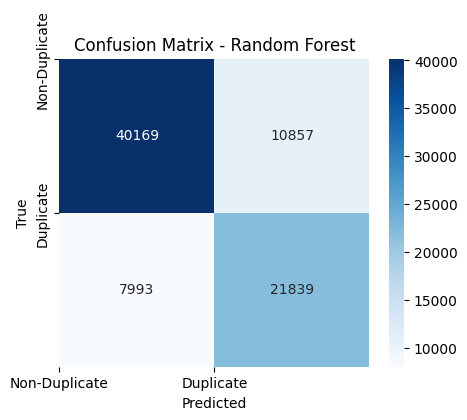

In [ ]:

# Calculate the confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm_rf, annot=True, cmap="Blues", fmt="d")

# Set labels, title, and ticks
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Random Forest")

# Set tick labels
tick_labels = ['Non-Duplicate', 'Duplicate']
plt.xticks(np.arange(2), tick_labels)
plt.yticks(np.arange(2), tick_labels)

# Display the plot
plt.show()


## The random forest model gives an accuracy of 76.68 and F1 score of 69.85

## **XGBoost**

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid_xgb = {
    'n_estimators': [300,500],
    'learning_rate': [0.1, 0.3],
    'max_depth': [3, 5, 7],
    'gamma': [0, 0.1],
    'scale_pos_weight': [1, 3, 5]
}

In [ ]:
# Instantiate the xgboost
xgb = XGBClassifier()

# Instantiate GridSearchCV
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=2, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search_xgb.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters found for xgb: ", grid_search_xgb.best_params_)
print("Best accuracy score for xgb: ", grid_search_xgb.best_score_)

# Use the best estimator to make predictions
best_xgb = grid_search_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

# Evaluate the best estimator
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)

Fitting 2 folds for each of 72 candidates, totalling 144 fits
Best parameters found for xgb:  {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500, 'scale_pos_weight': 1}
Best accuracy score for xgb:  0.762019285654487


In [ ]:
# Print the evaluation results
print("XGBoost - Best Estimator - Accuracy:", accuracy_xgb)
print("XGBoost - Best Estimator - Precision:", precision_xgb)
print("XGBoost - Best Estimator - Recall:", recall_xgb)
print("XGBoost - Best Estimator - F1 Score:", f1_xgb)

XGBoost - Best Estimator - Accuracy: 0.7672710183284276
XGBoost - Best Estimator - Precision: 0.6747477311671003
XGBoost - Best Estimator - Recall: 0.7127916331456154
XGBoost - Best Estimator - F1 Score: 0.6932481335376389


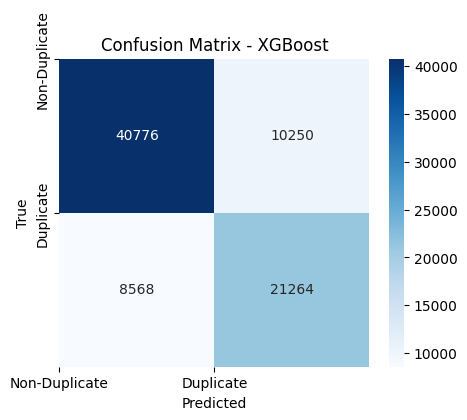

In [ ]:

# Calculate the confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm_xgb, annot=True, cmap="Blues", fmt="d")

# Set labels, title, and ticks
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - XGBoost")

# Set tick labels
tick_labels = ['Non-Duplicate', 'Duplicate']
plt.xticks(np.arange(2), tick_labels)
plt.yticks(np.arange(2), tick_labels)

# Display the plot
plt.show()


## The XGBoost gives an Accuracy of 76.72 and an F1 score of 69.32.

# **NaiveBayes**

In [ ]:

from sklearn.naive_bayes import MultinomialNB
# Define the parameter grid
param_grid_mnb = {
    'alpha': [0.0, 0.5, 1.0, 1.5, 2.0],
    'fit_prior': [True, False]
}

In [ ]:
warnings.filterwarnings('ignore')
# Instantiate the xgboost
Mnb = MultinomialNB(force_alpha=True)

# Instantiate GridSearchCV
grid_search_Mnb = GridSearchCV(estimator=Mnb, param_grid=param_grid_mnb, cv=2, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search_Mnb.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters found for mnb: ", grid_search_Mnb.best_params_)
print("Best accuracy score for mnb: ", grid_search_Mnb.best_score_)

# Use the best estimator to make predictions
best_mnb = grid_search_Mnb.best_estimator_
y_pred_mnb = best_mnb.predict(X_test)

# Evaluate the best estimator
accuracy_mnb = accuracy_score(y_test, y_pred_mnb)
precision_mnb = precision_score(y_test, y_pred_mnb)
recall_mnb = recall_score(y_test, y_pred_mnb)
f1_mnb = f1_score(y_test, y_pred_mnb)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
Best parameters found for mnb:  {'alpha': 0.0, 'fit_prior': True}
Best accuracy score for mnb:  0.643192559725404


In [ ]:
# Print the evaluation results
print("NaiveBayes - Best Estimator - Accuracy:", accuracy_mnb)
print("NaiveBayes - Best Estimator - Precision:", precision_mnb)
print("NaiveBayes - Best Estimator - Recall:", recall_mnb)
print("NaiveBayes - Best Estimator - F1 Score:", f1_mnb)

NaiveBayes - Best Estimator - Accuracy: 0.6435850503351555
NaiveBayes - Best Estimator - Precision: 0.5118035002679966
NaiveBayes - Best Estimator - Recall: 0.7361893268972916
NaiveBayes - Best Estimator - F1 Score: 0.603824422968533


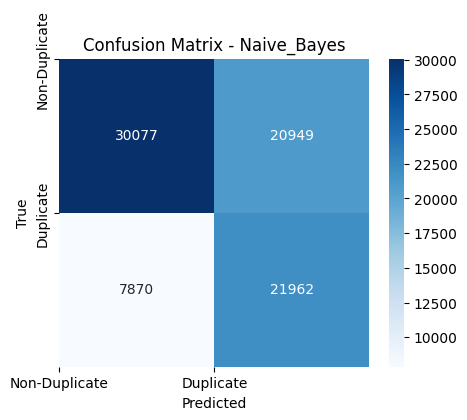

In [ ]:
# Calculate the confusion matrix
cm_mnb = confusion_matrix(y_test, y_pred_mnb)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm_mnb, annot=True, cmap="Blues", fmt="d")

# Set labels, title, and ticks
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Naive_Bayes")

# Set tick labels
tick_labels = ['Non-Duplicate', 'Duplicate']
plt.xticks(np.arange(2), tick_labels)
plt.yticks(np.arange(2), tick_labels)

# Display the plot
plt.show()

## The Naive Bayes model gives an Accuracy of 64.35 and F1 score of 60.38.

## **Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
# Define the parameter grid
param_grid_lg = {
    'C': [0.01, 0.1, 1],
    'penalty': ['l2'],
    'solver': ['liblinear'],
    'class_weight':['balanced','none']

}

In [ ]:
# Suppress specific warnings

# Instantiate the xgboost
lgr = LogisticRegression()

# Instantiate GridSearchCV
grid_search_lg = GridSearchCV(estimator=lgr, param_grid=param_grid_lg, cv=2, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search_lg.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters found for lg: ", grid_search_lg.best_params_)
print("Best accuracy score for lg: ", grid_search_lg.best_score_)

# Use the best estimator to make predictions
best_lg = grid_search_lg.best_estimator_
y_pred_lg = best_lg.predict(X_test)

# Evaluate the best estimator
accuracy_lg = accuracy_score(y_test, y_pred_lg)
precision_lg = precision_score(y_test, y_pred_lg)
recall_lg = recall_score(y_test, y_pred_lg)
f1_lg = f1_score(y_test, y_pred_lg)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
Best parameters found for lg:  {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
Best accuracy score for lg:  0.6911974001659145


In [ ]:
# Print the evaluation results
print("LogisticRegression - Best Estimator - Accuracy:", accuracy_lg)
print("LogisticRegression - Best Estimator - Precision:", precision_lg)
print("LogisticRegression - Best Estimator - Recall:", recall_lg)
print("LogisticRegression - Best Estimator - F1 Score:", f1_lg)

LogisticRegression - Best Estimator - Accuracy: 0.6946498800366074
LogisticRegression - Best Estimator - Precision: 0.564822752256568
LogisticRegression - Best Estimator - Recall: 0.7509385894341647
LogisticRegression - Best Estimator - F1 Score: 0.6447175295708982


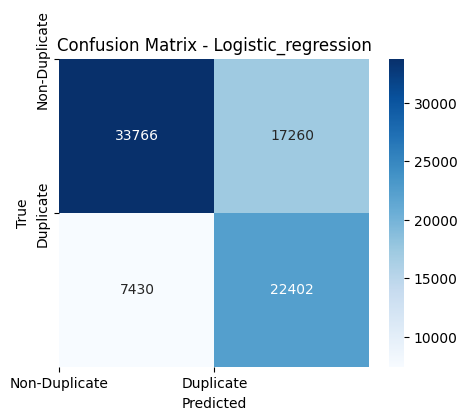

In [ ]:
# Calculate the confusion matrix
cm_lg = confusion_matrix(y_test, y_pred_lg)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm_lg, annot=True, cmap="Blues", fmt="d")

# Set labels, title, and ticks
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Logistic_regression")

# Set tick labels
tick_labels = ['Non-Duplicate', 'Duplicate']
plt.xticks(np.arange(2), tick_labels)
plt.yticks(np.arange(2), tick_labels)

# Display the plot
plt.show()

## The Logistic regression Model gives an Accuracy of 69.46 anf F1 score of 64.47.

# **MODEL COMPARISON**

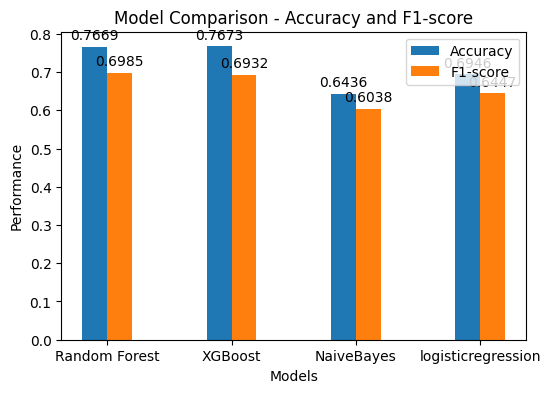

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

models = ['Random Forest', 'XGBoost','NaiveBayes','logisticregression']
accuracy_values = [accuracy_rf, accuracy_xgb,accuracy_mnb,accuracy_lg]
f1_macro_avg_values = [f1_rf, f1_xgb, f1_mnb,f1_lg]

bar_width = 0.20

r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]

fig, ax = plt.subplots(figsize=(6, 4))
rects1 = ax.bar(r1, accuracy_values, width=bar_width, label='Accuracy')
rects2 = ax.bar(r2, f1_macro_avg_values, width=bar_width, label='F1-score')

for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.4f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

ax.set_xlabel('Models')
ax.set_ylabel('Performance')
ax.set_xticks([r + bar_width/2 for r in range(len(models))])
ax.set_xticklabels(models)
ax.set_title('Model Comparison - Accuracy and F1-score')
ax.legend()

plt.show()

# **Conclusion**
From the above Model results it is clear that our two best models are XGboost
with an accuracy of 76.73 and RandomForest with an accuracy of 76.69. According
to accuracy, the XGBoost model gives a slightly better result than RandomForest.
While these machine learning models provided strong baseline results, there is potential for further enhancement using advanced deep learning techniques and natural language processing (NLP) methods. Specifically, incorporating models such as Long Short-Term Memory (LSTM) networks, Bidirectional LSTM (biLSTM), Gated Recurrent Units (GRU), and transformer-based models like BERT could significantly improve the detection accuracy. These models are well-suited for capturing complex patterns and contextual information in textual data, thereby offering a more nuanced understanding of the questions' semantic similarities.
